In [1]:
from scripts.segment import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def update_segment_report(segments,report):
    report.num_sim += 1
    report.num_segments.append(len(segments)) 
    
    pipe_segments = []
    for segment in segments:
        if len(segment.pids) > 0: 
            pipe_segments.append(segment)
    report.pipe_seg_report.pipe_segments.append(pipe_segments)
    return report
    
def simulate_segments(grid_size,valves_dict):
    A = assemble_adjacency_mtx(grid_size,valves_dict)
    segments = find_segments(A,grid_size*grid_size)
    return segments

def generate_valves_dict(valve_register,x,fail_rate):
    valve_register.recover_valves()
    if x == 0:
        vids2fail = generate_vids2fail(list(valve_register.vid2v.keys()),fail_rate)
    else:
        # N-x setting 
        config_fvids,remained_vids = generate_nx_config(valve_register,x)
        vids2fail = generate_vids2fail(remained_vids,fail_rate)
        vids2fail+= config_fvids
    valves_dict = fail_valves(valve_register.vid2v,vids2fail)
    return valves_dict
    

def generate_sim_report_nx(grid_size,num_simulation,x,fail_rate):
    report = SegmentReport(grid_size)
    valves = generate_valves_grid(grid_size)
    valve_register = ValveRegister()
    register_valves(valves,valve_register)
    for i in range(num_simulation):
        valves_dict = generate_valves_dict(valve_register,x,fail_rate)
        segments = simulate_segments(grid_size,valves_dict)
        report = update_segment_report(segments,report)
    return report


    

In [3]:
def fail_valves(valves_dict, vids2fail):
    for vid,v in valves_dict.items():
        if vid in vids2fail:
            v.fail = True
    return valves_dict

In [4]:
def generate_nx_config(valve_register,x):
    nid2valve = valve_register.nid2v
    vids2fail = []
    for _,valves in nid2valve.items():
        removed_valves = np.random.choice(valves, x, replace=False)
        for removed_valve in removed_valves:
            vids2fail.append(removed_valve.vid)
    
    vids = valve_register.vid2v.keys()
    remained_vids = list(set(vids)-set(vids2fail))

    return vids2fail,remained_vids


In [5]:
def generate_vids2fail(vids,fail_rate):
    num_failed_valves = int(fail_rate*len(vids))
    rand_fvids = list(np.random.choice(vids, num_failed_valves, replace=False))
    return rand_fvids


In [6]:
class PipeSegmentStat(object):
    def __init__(self,tot_num_pipes):
        self.tot_num_pipes = tot_num_pipes
        self.seg_pipes_num = self._init_seg_pipes_dict()
        self.seg_sizes_max = []
        self.seg_sizes_mean = []
        self.num_pipe_seg = 0 
        self.num_multi_pipe_seg = 0
        
    def _init_seg_pipes_dict(self):
        pipe_num_dict = {}
        for i in range(self.tot_num_pipes):
            pipe_num_dict[i+1] = 0
        return pipe_num_dict
    
    def analyze_pipe_segs(self,pipe_segments):
        num_segs,num_multi_segs = [], []
        for segs in pipe_segments:
            num_segs.append(len(segs))
            num_pipes_sim = []
            for pipe_seg in segs:
                num_pipes_seg = len(pipe_seg.pids)
                num_pipes_sim.append(num_pipes_seg)
                self.seg_pipes_num[num_pipes_seg] += 1
            
            self.seg_sizes_max.append(np.max(num_pipes_sim))
            self.seg_sizes_mean.append(np.mean(num_pipes_sim))
            num_multi_segs.append(np.count_nonzero(np.array(num_pipes_sim)-1))
        self.num_pipe_seg = np.mean(num_segs)
        self.num_multi_pipe_seg = np.mean(num_multi_segs)

class PipeSegmentReport(object):
    def __init__(self,grid_size):
        self.tot_num_pipes = 2*(grid_size-1)*grid_size
        self.pipe_segments = []
        self.stat = PipeSegmentStat(self.tot_num_pipes)
    
    def update_stat(self):
        self.stat = PipeSegmentStat(self.tot_num_pipes)
        self.stat.analyze_pipe_segs(self.pipe_segments)

#     def __str__(self):  
#         return f"num_nontrivial_seg: {}, max_num_pipes number: {}, \
#         average_num_pipes {}, average_num_multipipe is {}, \
#         prob to multiseg {}" 

class SegmentReport(object):
    def __init__(self,grid_size):
        self.grid_size = grid_size
        self.num_sim = 0
        self.num_segments = []
        self.pipe_seg_report = PipeSegmentReport(grid_size)
    
    def __str__(self):  
        pipe_seg_ratio = self.num_pipe_segments/self.num_pipes
#         print (self.pipe_seg_report)
        return "pipes number:  %d, segment number: %d, pipe segment number %d, pipe_seg_ratio is %f" % (
            self.num_pipes, self.num_segments,self.num_pipe_segments, pipe_seg_ratio)  

    def get_segments_stats(self):
        self.pipe_seg_report.update_stat()
        return self.pipe_seg_report.stat
        
        
generate_sim_report_nx(10,10,2,0.2)

In [7]:
def get_simulation_results(reports):
    ave_num_segments = []
    ave_seg_pipe_size = []
    ave_max_pipe_seg = []
    for report in reports:
        stat = report.get_segments_stats()
        ave_num_segments.append(stat.num_multi_pipe_seg)
        ave_seg_pipe_size.append(np.mean(stat.seg_sizes_mean))
        ave_max_pipe_seg.append(np.mean(stat.seg_sizes_max))
    return ave_num_segments,ave_seg_pipe_size,ave_max_pipe_seg
        

In [8]:
def plot_reports(reports):
    ave_seg_pipe_size
    font = {'size'   : 16}
    matplotlib.rc('font', **font)

    plt.plot(fail_rates, ave_seg_pipe_size, label="mean", linewidth=2)
    plt.plot(fail_rates, ave_max_pipe_seg, label="max", linewidth=2)
    plt.xlabel('Valve failure rate ')
    plt.ylabel('Number of pipes per segment')
    plt.legend()
# plt.savefig('../results/fragility_curve.png',dpi=300, bbox_inches='tight')
    
    
    

In [9]:
grid_size = 20
num_simulation = 1000
num_test = 20
fail_rates = np.linspace(0, 1, num=num_test)

from functools import partial
from multiprocessing import Pool

pool = Pool(processes=num_test)


In [10]:
sim_report_n = partial(generate_sim_report_nx,grid_size,num_simulation,0)
reports = pool.map(sim_report_n,fail_rates)
n_report = get_simulation_results(reports)

# print (report)

In [11]:
sim_report_n1 = partial(generate_sim_report_nx,grid_size,num_simulation,1)
reports = pool.map(sim_report_n1,fail_rates )
n1_report = get_simulation_results(reports)

In [12]:
sim_report_n2 = partial(generate_sim_report_nx,grid_size,num_simulation,2)
reports = pool.map(sim_report_n2,fail_rates )
n2_report = get_simulation_results(reports)

# print (report)

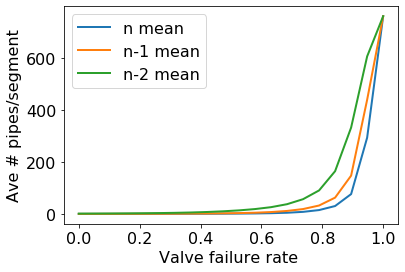

In [13]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

plt.plot(fail_rates, n_report[1], label="n mean", linewidth=2)
plt.plot(fail_rates, n1_report[1], label="n-1 mean", linewidth=2)
plt.plot(fail_rates, n2_report[1], label="n-2 mean", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/segment')
plt.legend()
plt.savefig('./results/ave_pipes_seg.png',dpi=300, bbox_inches='tight')

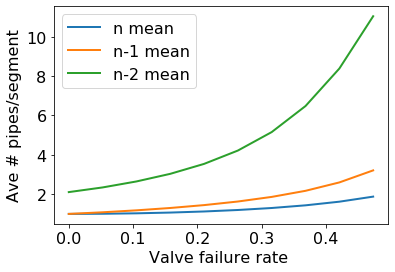

In [14]:
n = 10
plt.plot(fail_rates[:n], n_report[1][:n], label="n mean", linewidth=2)
plt.plot(fail_rates[:n], n1_report[1][:n], label="n-1 mean", linewidth=2)
plt.plot(fail_rates[:n], n2_report[1][:n], label="n-2 mean", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/segment')
plt.legend()
plt.savefig('./results/ave_pipes_seg_small.png',dpi=300, bbox_inches='tight')

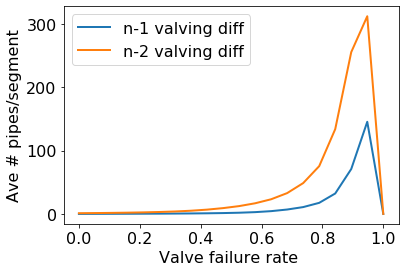

In [15]:
plt.plot(fail_rates, np.array(n1_report[1])-np.array(n_report[1]), label="n-1 valving diff", linewidth=2)
plt.plot(fail_rates, np.array(n2_report[1])-np.array(n_report[1]), label="n-2 valving diff", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.savefig('./results/ave_pipes_seg_diff.png',dpi=300, bbox_inches='tight')

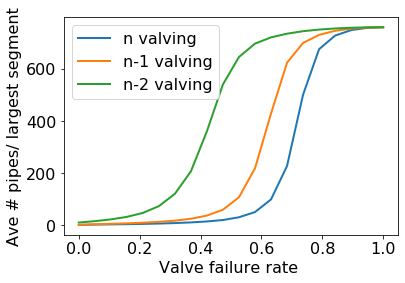

In [16]:
plt.plot(fail_rates, n_report[2], label="n valving", linewidth=2)
plt.plot(fail_rates, n1_report[2], label="n-1 valving", linewidth=2)
plt.plot(fail_rates, n2_report[2], label="n-2 valving", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/ largest segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.savefig('./results/ave_pipes_largest_seg.png',dpi=300, bbox_inches='tight')

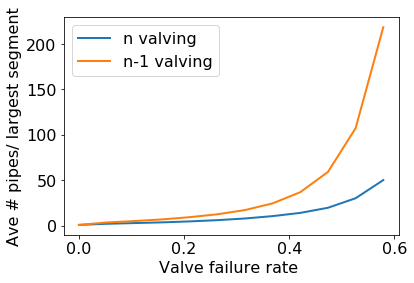

In [17]:
n = 12
plt.plot(fail_rates[:n], n_report[2][:n], label="n valving", linewidth=2)
plt.plot(fail_rates[:n], n1_report[2][:n], label="n-1 valving", linewidth=2)
# plt.plot(fail_rates[:n], n2_report[2][:n], label="n-2 valving", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/ largest segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.savefig('./results/ave_pipes_largest_seg_small.png',dpi=300, bbox_inches='tight')

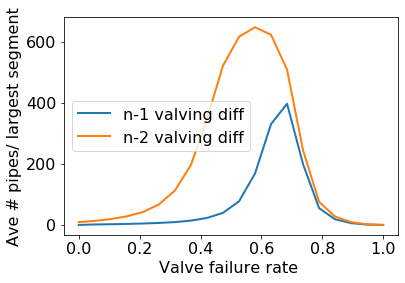

In [18]:
plt.plot(fail_rates, np.array(n1_report[2])-np.array(n_report[2]), label="n-1 valving diff", linewidth=2)
plt.plot(fail_rates, np.array(n2_report[2])-np.array(n_report[2]), label="n-2 valving diff", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/ largest segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.savefig('./results/ave_pipes_largest_seg_diff.png',dpi=300, bbox_inches='tight')

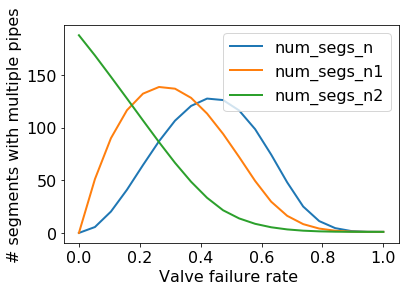

In [19]:
plt.plot(fail_rates, n_report[0], label="num_segs_n", linewidth=2)
plt.plot(fail_rates, n1_report[0], label="num_segs_n1", linewidth=2)
plt.plot(fail_rates, n2_report[0], label="num_segs_n2", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('# segments with multiple pipes')
plt.legend()
plt.savefig('./results/num_notrivial_segs.png',dpi=300, bbox_inches='tight')

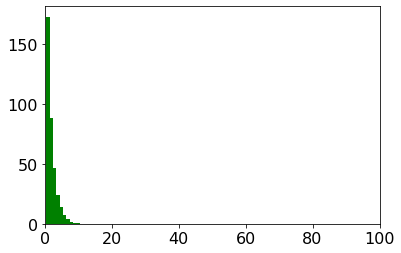

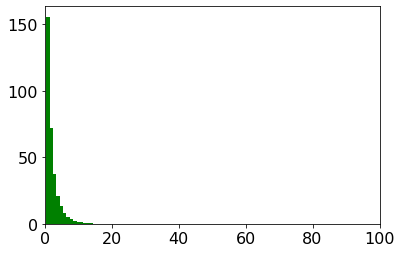

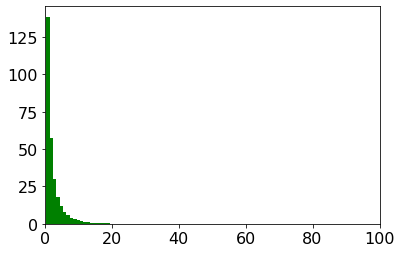

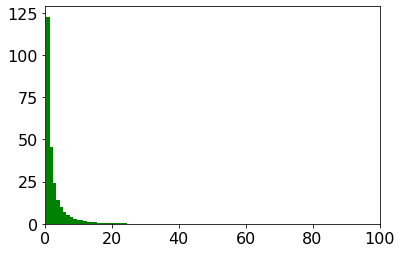

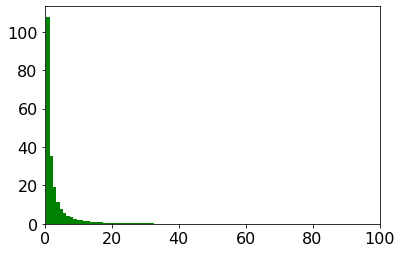

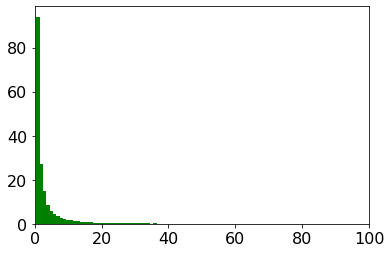

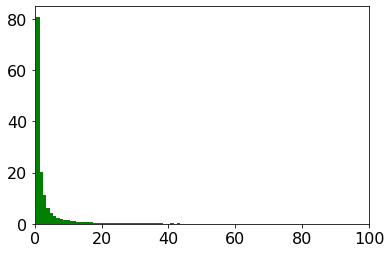

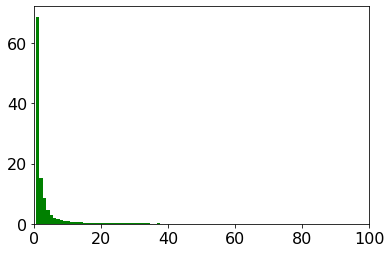

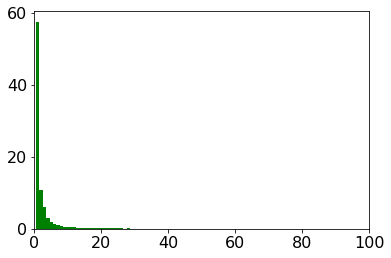

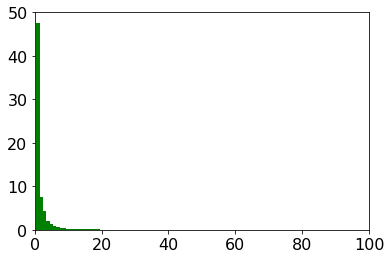

In [20]:
for report in reports[:10]:
    stat = report.get_segments_stats()
    num_pipes_dist = stat.seg_pipes_num
#     print (report.num_simulation)
    
    counts = np.array(list(num_pipes_dist.values()))/num_simulation
#     perc = counts/stat.tot_num_pipes * 100
    plt.bar(num_pipes_dist.keys(), counts, 1, color='g')
    plt.xlim(left = 0, right=100)
    plt.show()
    